# Evaluation of trained network for temporal super-resolution

In [ ]:
#%matplotlib notebook
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
from IPython.display import display
from utils.evaluate_utils import *
import pandas as pd
from collections import defaultdict
plt.rcParams['figure.figsize'] = [10, 8]
%matplotlib inline

In [ ]:
df = pd.read_csv('../results/Overview_models.csv')
df1 = df[['Name', 'notes']]
# display(df1)
pd.set_option("max_colwidth", None)
display(df1)

In [ ]:
# model_names  = ['20230301-1641', '20230301-1654', '20230301-1704', '20230305-1001', '20230305-1002', '20230305-1008', '20230305-1107'     , '20230306-1120']
# tabular_names = ['ResNet_8_4'   , 'DenseNet_8_4' , 'CSPNet_8_4'   , 'ResNet_4_2'   ,'ResNet_6_6'    , 'ResNet_4_8'   , 'ResNet_Conv3DT_8_4', 'ResNet_NN_8_4']

model_names  = ['20230308-1226', '20230313-0948']#'*', '20230313-0951']#['20230301-1641', '20230301-1654', '20230301-1704', '20230305-1001', '20230305-1002', '20230305-1008', '20230305-1107'     , '20230306-1120']
tabular_names =['Dyn_ResNet', 'Dn_DenseNet']    #, 'Dyn_CSPNet']#['ResNet_8_4'   , 'DenseNet_8_4' , 'CSPNet_8_4'   , 'ResNet_4_2'   ,'ResNet_6_6'    , 'ResNet_4_8'   , 'ResNet_Conv3DT_8_4', 'ResNet_NN_8_4']
set_name = 'Test'               
data_model= '4'
step = 2
use_dyn_mask = True

### Define helper functions


In [ ]:
vel_colnames=['u', 'v', 'w']
vel_colnames_fluid = ['u_fluid', 'v_fluid', 'w_fluid']

def load_data(model_name, set_name, data_model, step,dynamic_mask_used, ending_file= ''):
    #directories
    gt_dir = '../data/CARDIAC'
    result_dir = f'../results/Temporal4DFlowNet_{model_name}'
    eval_dir = f'{result_dir}/plots'
    lr_dir = '../data/CARDIAC'

    inbetween_string = ''
    if dynamic_mask_used:
        inbetween_string = '_dynamic'

    #filenames
    gt_filename = f'M{data_model}_2mm_step{step}_static{inbetween_string}.h5'
    lr_filename = f'M{data_model}_2mm_step{step}_static{inbetween_string}_noise.h5'
    result_filename = f'{set_name}set_result_model{data_model}_2mm_step{step}_{model_name[-4::]}_temporal{ending_file}.h5' #_newpadding
    evaluation_filename = f'eval_rel_err_{data_model}_2mm_step{step}_{model_name[-4::]}_temporal.h5'

    print(gt_filename, lr_filename)

    if not os.path.isdir(eval_dir):
        os.makedirs(eval_dir)

    #Params for evalation
    save_relative_error_file= False

    # Setting up
    gt_filepath = '{}/{}'.format(gt_dir, gt_filename)
    res_filepath = '{}/{}'.format(result_dir, result_filename)
    lr_filepath = '{}/{}'.format(lr_dir, lr_filename)
    

    if save_relative_error_file:
        assert(not os.path.exists(f'{result_dir}/{evaluation_filename}')) #STOP if relative error file is already created

    
    gt = {}
    lr = {}
    pred = {}

    with h5py.File(res_filepath, mode = 'r' ) as h_pred:
        with h5py.File(gt_filepath, mode = 'r' ) as h_gt:
            with h5py.File(lr_filepath, mode = 'r' ) as h_lr:
                
                gt["mask"] = np.asarray(h_gt["mask"]).squeeze()
                gt["mask"][np.where(gt["mask"] !=0)] = 1
                if len(gt['mask'].shape) == 4 : # check for dynamical mask, otherwise create one
                    temporal_mask = gt['mask'].copy()
                else:
                    print('Create static temporal mask for model')
                    temporal_mask = create_temporal_mask(gt["mask"], h_gt['u'].shape[0])
                gt['mask'] = temporal_mask.copy()
                # adapt dimension
                for vel in vel_colnames:
                    
                    gt[vel] =   np.asarray(h_gt[vel])
                    pred[vel] = np.asarray(h_pred[f'{vel}_combined']) 
                    lr[vel] =   np.asarray(h_lr[vel])[::2, :, :, :]       

                    # add information considering only the fluid regions  
                    pred[f'{vel}_fluid'] =np.multiply(pred[vel], temporal_mask)
                    lr[f'{vel}_fluid'] =  np.multiply(lr[vel], temporal_mask[::2, :, :, :])
                    gt[f'{vel}_fluid'] =  np.multiply(gt[vel], temporal_mask)

                    
                #include speed calculations
                gt['speed']   = np.sqrt(gt["u"]**2 + gt["v"]**2 + gt["w"]**2)
                lr['speed']   = np.sqrt(lr["u"]**2 + lr["v"]**2 + lr["w"]**2)
                pred['speed'] = np.sqrt(pred["u"]**2 + pred["v"]**2 + pred["w"]**2)


    return lr, gt, pred, temporal_mask, eval_dir

def load_interpolation(data_model, step, lr, gt, use_dynamical_mask):
    
    interpolate_NN = {}
    interpolate_linear = {}
    interpolate_cubic = {}

    inbetween_string = ''
    if use_dynamical_mask:
        inbetween_string = '_dynamic'

    lr_filename = f'M{data_model}_2mm_step{step}_static{inbetween_string}_noise.h5'


    interpolation_file= f'../results/interpolation/{lr_filename[:-3]}_interpolation'
    if not os.path.isfile(interpolation_file):
        print("Interpolation file does not exist - calculate interpolation and save files")
        print("Save interpolation files to: ", interpolation_file)
        
        #this can take a while
        for vel in vel_colnames:
            print("Interpolate low resolution images - ", vel)
            
            interpolate_linear[vel] = temporal_linear_interpolation(lr[vel], gt[vel].shape)
            interpolate_linear[f'{vel}_fluid'] = np.multiply(interpolate_linear[vel], gt['mask'])

            interpolate_cubic[vel] = temporal_cubic_interpolation(lr[vel], gt[vel].shape)
            interpolate_cubic[f'{vel}_fluid'] = np.multiply(interpolate_cubic[vel], gt['mask'])

            interpolate_NN[vel] = temporal_NN_interpolation(lr[vel], gt[vel].shape)
            interpolate_NN[f'{vel}_fluid'] = np.multiply(interpolate_NN[vel], gt['mask'])

            prediction_utils.save_to_h5(interpolation_file, f'linear_{vel}' , interpolate_linear[vel], compression='gzip')
            prediction_utils.save_to_h5(interpolation_file, f'cubic_{vel}' , interpolate_cubic[vel], compression='gzip')
            prediction_utils.save_to_h5(interpolation_file, f'NN_{vel}' , interpolate_NN[vel], compression='gzip')
    else:
        print("Load existing interpolation file")
        with h5py.File(interpolation_file, mode = 'r' ) as h_interpolate:
            for vel in vel_colnames:
                interpolate_linear[vel] = np.array(h_interpolate[f'linear_{vel}'])
                interpolate_cubic[vel] =  np.array(h_interpolate[f'cubic_{vel}'])
                interpolate_NN[vel] =     np.array(h_interpolate[f'NN_{vel}'])


                interpolate_linear[f'{vel}_fluid'] = np.multiply(interpolate_linear[vel], gt['mask'])
                interpolate_cubic[f'{vel}_fluid'] = np.multiply(interpolate_cubic[vel], gt['mask'])
                interpolate_NN[f'{vel}_fluid'] = np.multiply(interpolate_NN[vel], gt['mask'])

    return interpolate_linear, interpolate_cubic, interpolate_NN

def get_evaluation_metrics(results, prediction, ground_truth,temporal_mask, t_peak_flow):
    '''
    Append error variables into dict 
    '''
    RMSEx, std_RMSEx = calculate_rmse(prediction['u_fluid'][t_peak_flow], ground_truth['u_fluid'][t_peak_flow], temporal_mask[t_peak_flow], return_variance = True)
    RMSEy, std_RMSEy = calculate_rmse(prediction['v_fluid'][t_peak_flow], ground_truth['v_fluid'][t_peak_flow], temporal_mask[t_peak_flow], return_variance = True)
    RMSEz, std_RMSEz = calculate_rmse(prediction['w_fluid'][t_peak_flow], ground_truth['w_fluid'][t_peak_flow], temporal_mask[t_peak_flow], return_variance = True)
    results['RMSEx'].append(RMSEx[0])
    results['RMSEy'].append(RMSEy[0])
    results['RMSEz'].append(RMSEz[0])
    results['RMSEx_std'].append(std_RMSEx[0])
    results['RMSEy_std'].append(std_RMSEy[0])
    results['RMSEz_std'].append(std_RMSEz[0])
    kx, R2_x = calculate_k_R2(prediction['u'][t_peak_flow], ground_truth['u'][t_peak_flow], temporal_mask[t_peak_flow])
    ky, R2_y = calculate_k_R2(prediction['v'][t_peak_flow], ground_truth['v'][t_peak_flow], temporal_mask[t_peak_flow])
    kz, R2_z = calculate_k_R2(prediction['w'][t_peak_flow], ground_truth['w'][t_peak_flow], temporal_mask[t_peak_flow])

    results['kx'].append(kx)
    results['ky'].append(ky)
    results['kz'].append(kz)
    results['R_2x'].append(R2_x)
    results['R_2y'].append(R2_y) 
    results['R_2z'].append(R2_z) 
    results['RE'].append(calculate_relative_error_normalized(prediction["u"], prediction["v"], prediction["w"], ground_truth["u"], ground_truth["v"] , ground_truth["w"], ground_truth["mask"])[t_peak_flow])

    return results

### Tabulate plots

In [ ]:

dict_results = defaultdict(list)#{ 'Name', 'RMSEx', 'RMSEy', 'RMSEz', 'k','k_bounds',  'R_2','R_bounds', 'RE', 'RE_bounds'}

lr, gt, _,temporal_mask, _ = load_data(model_names[0], set_name, data_model, step, use_dyn_mask)

peak_flow_frame = np.unravel_index(np.argmax(gt['speed']), shape = gt['speed'].shape)[0]
print("Peak flow frame:", peak_flow_frame)
if peak_flow_frame%2 == 0: 
    peak_flow_frame +=1
    print("Peak flow frame changed to:", peak_flow_frame)


In [ ]:
for m_name, t_name in zip(model_names, tabular_names):
    _, gt_1, prediction_1,temporal_mask_1, _ = load_data(m_name, set_name, data_model, step, dynamic_mask_used = use_dyn_mask) #load data
    dict_results['Network'].append(t_name)
    dict_results = get_evaluation_metrics(dict_results,prediction_1,gt_1, temporal_mask_1,peak_flow_frame) #evaluate

In [ ]:
# load interpolation files and evaulate those with given data
interpolate_linear, interpolate_cubic, interpolate_NN = load_interpolation(data_model, step,lr, gt, use_dynamical_mask = use_dyn_mask)

dict_results['Network'].append('Linear interpolation')
dict_results = get_evaluation_metrics(dict_results,interpolate_linear,gt,temporal_mask, peak_flow_frame)

dict_results['Network'].append('Cubic interpolation')
dict_results = get_evaluation_metrics(dict_results,interpolate_cubic,gt,temporal_mask, peak_flow_frame)

rel_error_lin_interpolation =   calculate_relative_error_normalized(interpolate_linear["u"], interpolate_linear["v"], interpolate_linear["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
rel_error_cubic_interpolation = calculate_relative_error_normalized(interpolate_cubic["u"], interpolate_cubic["v"], interpolate_cubic["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])

gt['mean_speed'] = calculate_mean_speed(gt["u_fluid"], gt["v_fluid"] , gt["w_fluid"], gt["mask"])

r_dt = pd.DataFrame(dict_results).round(4)
display(r_dt)


In [ ]:
#Print for latex tabular
print(r_dt.to_latex(index=False))

In [ ]:
vel_colnames = ['u', 'v', 'w']
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(gt[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(gt[vel][np.where(temporal_mask !=0)].flatten(), 0.99)

### Peak flow frame comparison of different networks

In [ ]:
#Params for plot
patch_size = 1
show_avg = False
show_pixel = True
def compare_peak_flow_pixel(gt,lr, model_names, set_names, labels, colors,name_comparison,patch_size, show_avg, show_pixel, use_dynamical_mask = False):

    plt.figure(figsize=(7, 5))
    def show_peak_flow_pixel(x, pred_data, label, color, line_style = '-'):
        '''Plot peak flow vosel in time and also averages cube around it '''
    
        if show_pixel: # show only flow of peak flow voxel 
            plt.plot(x, pred_data['speed'][:, idx_max[1], idx_max[2], idx_max[3]]*100,line_style, label = f'{label} pixel', color = color)

        if show_avg: # show average flow of  region around peak flow voxel. Regsion is depending on patch size
            plt.plot(x, np.average(pred_data['speed']  [:, idx_max[1]-patch_size:idx_max[1]+patch_size+1, idx_max[2]-patch_size:idx_max[2]+patch_size+1, idx_max[3]-patch_size:idx_max[3]+patch_size+1], axis = (1, 2, 3))*100,line_style,label = f'{label} avg', color = color)
    
    # get voxel with maximum flow
    idx_max = np.unravel_index(np.argmax(gt['speed']), shape = gt['speed'].shape)
    x = np.arange(gt['speed'].shape[0])

    show_peak_flow_pixel(x, gt, label = 'gt', color='black')
    show_peak_flow_pixel(x[::2 ], lr, label= 'low res',color='yellowgreen',line_style='-o')


    for m_name, s_name, label, color in zip(model_names, set_names, labels, colors):
        lr_1, gt_1, prediction_1,temporal_mask_1, _ = load_data(m_name, s_name, data_model, step, dynamic_mask_used = use_dynamical_mask)
        show_peak_flow_pixel(x, prediction_1, label, color, line_style='--')

    if show_avg:
        plt.title(f"Speed at pixel {idx_max[1::]} with average of number of voxels: {(2*patch_size+1)**3}")
    else:
         plt.title(f"Speed at pixel {idx_max[1::]}")
    plt.ylabel('Speed (cm/s)')
    plt.xlabel('Frame')
    plt.legend()
    plt.show()
    

In [63]:
cmaps = [ plt.cm.Blues,plt.cm.Reds]

network_prediction = {}
error_pointwise = {}
for m_name, t_name in zip(model_names, tabular_names):
    _, _, network_prediction[t_name],_, _ = load_data(m_name, set_name, data_model, step, dynamic_mask_used = use_dyn_mask) #load data
    _, error_pointwise[t_name] = calculate_pointwise_error(network_prediction[t_name]['u'], network_prediction[t_name]['v'], network_prediction[t_name]['w'], gt["u"], gt["v"] , gt["w"], gt["mask"])

@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1), vel=vel_colnames)
def f(frame=5, x = 10, vel = "u"):
    plt.figure(figsize=(20,10))
    frames = gt['u'].shape[0]
    #N_row =  4 + len(model_names)
    N = 3 + len(model_names)
    idxs = np.index_exp[frame, x, :, :]
    idx_error = np.index_exp[:, x, :, :]

    plt.subplot(2, N, 1)
    if frame%2 == 0:
        plt.imshow(lr[vel][frame//2, x, :, :],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    else:
        plt.imshow(np.zeros_like(lr[vel][frame//2, x, :, :]), vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("LR")
    plt.axis('off')

    plt.subplot(2, N, 2)
    plt.imshow(gt[vel][idxs], vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("GT")
    plt.axis('off')
    for i, t_name in enumerate(tabular_names):

        plt.subplot(2, N, 3+i)
        plt.imshow(network_prediction[t_name][vel][idxs],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
        plt.title(t_name)
        plt.axis('off')

    
    
    for i, t_name in enumerate(tabular_names):
        plt.subplot(2, N, N + 3 +i)
        plt.imshow(error_pointwise[t_name][vel][idxs],cmap= 'viridis')
        plt.axis('off')

    # points_in_mask = np.where(temporal_mask[idx_error] !=0)
    # print(error_pointwise.keys())
    # for i, t_name in enumerate(tabular_names):
        
    #     error_frames = error_pointwise[t_name][vel][idx_error]
        
    #     error_frames = error_frames[: ,points_in_mask[1]].reshape(frames, -1)
    #     print(temporal_mask[idx_error].shape)
    #     error_frames = np.sum(error_frames, axis=1)/np.sum(temporal_mask[idx_error], axis = (1, 2))
    #     plt.plot(range(frames),error_frames,  label = t_name)
    #     plt.xlim([10, 40])

    #     #plt.imshow(error_pointwise[idxs], cmap='viridis')
    #     plt.title("Relative error")
        #plt.axis('off')

    # plt.subplot(1, N, 7)
    # plt.imshow(error_absolut[vel][idxs], cmap='viridis')
    # plt.title("Absolute error")
    # plt.axis('off')

    # plt.subplot(1, N, N-1)
    # plt.imshow(interpolate_linear[vel][idxs],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    # plt.title("Linear")
    # plt.axis('off')

    plt.subplot(2, N, N)
    plt.imshow(interpolate_cubic[vel][idxs],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("Cubic")
    plt.axis('off')


    plt.tight_layout()
    #plt.colorbar()
    # plt.show()

M4_2mm_step2_static_dynamic.h5 M4_2mm_step2_static_dynamic_noise.h5
M4_2mm_step2_static_dynamic.h5 M4_2mm_step2_static_dynamic_noise.h5


interactive(children=(IntSlider(value=5, description='frame', max=49), IntSlider(value=10, description='x', ma…

## Compare multiple models in the same set

In [26]:
def comparison_multiple_models(model_names, set_names, labels, colors,name_comparison, use_dynamical_mask = False):
    vel_colnames=['u', 'v', 'w']

    #plot realtive error
    plt.subplot(3, 1, 1)
    plt.title(f"Relative error - {set_name[0]}")
    plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
    plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
    plt.plot(50*np.ones(len(rel_error_cubic_interpolation)), 'k:')
    plt.xlabel("Frame")
    plt.ylabel("Relative error (%)")
    plt.ylim((0, 50))

    #Plot rmse
    plt.subplot(3, 1, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Frame')
    plt.title('RMSE')

    #Plot mean speed 
    plt.subplot(3, 1, 3)
    plt.plot(gt['mean_speed'], label ='Ground truth',color = 'black')
    # plt.plot(interpolate_linear['mean_speed'][:-1], label = 'linear interpolatiom', color = 'yellowgreen')
    # plt.plot(interpolate_cubic['mean_speed'][:-1] , label = 'cubic interpoaltion', color = 'forestgreen')
    plt.xlabel("Frame")
    plt.ylabel("Mean speed (cm/s)")
    plt.legend()

    for m_name, s_name, label, color in zip(model_names, set_names, labels, colors):
        lr_1, gt_1, prediction_1,temporal_mask_1, _ = load_data(m_name, s_name, data_model, step, dynamic_mask_used = use_dynamical_mask)
        rel_err = calculate_relative_error_normalized(prediction_1["u"], prediction_1["v"], prediction_1["w"], gt_1["u"], gt_1["v"] , gt_1["w"], gt_1["mask"])
        
        plt.subplot(3, 1, 1)
        plt.plot(rel_err, label=label, color= color)
        plt.legend()
        
        plt.subplot(3, 1, 2)
        plt.plot(calculate_rmse(prediction_1['speed'], gt_1['speed'], gt_1['mask']), label = f'{label}_speed', color= color)
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(calculate_mean_speed(prediction_1["u_fluid"], prediction_1["v_fluid"], prediction_1["w_fluid"],gt_1["mask"]), label = label, color= color)
        # plt.plot(calculate_mean_speed(gt_1["u_fluid"], gt_1["v_fluid"], gt_1["w_fluid"],gt_1["mask"]),'--', label = f'gt_{label}', color= 'black')

    plt.legend()
    plt.tight_layout()
    plt.savefig(f'../results/plots/ComparisonPlots/Error_comparison_{name_comparison}.svg',bbox_inches='tight')
    plt.show()

In [ ]:
# comparison_multiple_models(model_names, set_names, labels, colors,name_comparison, use_dyn_mask)

M4_2mm_step2_static_dynamic.h5 M4_2mm_step2_static_dynamic_noise.h5
M4_2mm_step2_static_dynamic.h5 M4_2mm_step2_static_dynamic_noise.h5


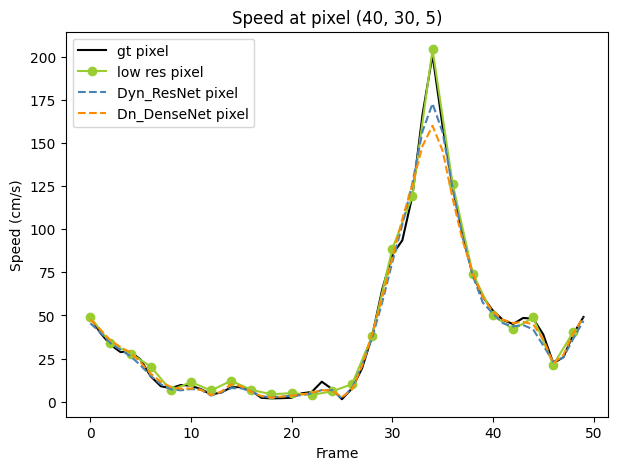

M4_2mm_step2_static_dynamic.h5 M4_2mm_step2_static_dynamic_noise.h5
max/min before tanh 48468.992 0.0
max/min after tanh 1.0 0.0
M4_2mm_step2_static_dynamic.h5 M4_2mm_step2_static_dynamic_noise.h5
max/min before tanh 46170.34 0.0
max/min after tanh 1.0 0.0


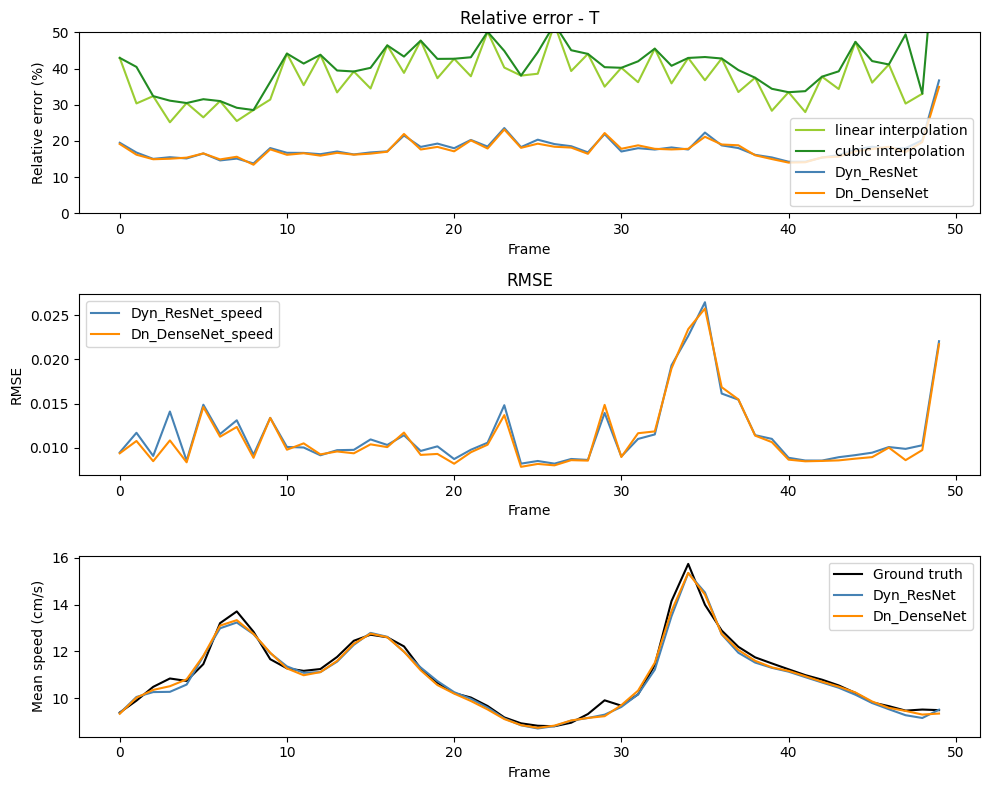

In [27]:
set_names = [set_name for _ in range(len(model_names))]
colors = ['steelblue', 'darkorange', 'brown', 'orchid', 'darkviolet']
compare_peak_flow_pixel(gt,lr, model_names, set_names, tabular_names, colors,'tabel',patch_size, show_avg, show_pixel, use_dynamical_mask = use_dyn_mask)
comparison_multiple_models(model_names, set_names, tabular_names, colors,'tabel', use_dyn_mask)

### Comparison depth resnet

In [ ]:
model_names = ['20230301-1641', '20230305-1001', '20230305-1002', '20230305-1008'] # resnet: Temporal4DFlowNet_20230301-1641 #
set_names = [set_name for _ in range(len(model_names))]
labels = [f'ResNet-Default-8-4_{set_names[0]}' , f'ResNet_4-2_{set_names[0]}', f'ResNet_6-6_{set_names[0]}', f'ResNet_4-8_{set_names[0]}']
colors = ['steelblue', 'darkorange', 'brown', 'orchid', 'darkviolet']
name_comparison = 'Depth'


comparison_multiple_models(model_names, set_names, labels, colors,name_comparison, use_dyn_mask)
compare_peak_flow_pixel(gt,lr, model_names, set_names, labels, colors,name_comparison,patch_size, show_avg, show_pixel, use_dynamical_mask = use_dyn_mask)

### Comparison sampling of data

In [ ]:
model_names = ['20230301-1641','20230301-1127'] 
set_names = [set_name for _ in range(len(model_names))]
labels = [f'ResNet-Cartesian_Sampling_{set_names[0]}',f'ResNet_RadialSampling_{set_names[0]}']
colors = ['steelblue','darkorange', 'brown', 'orchid', 'darkviolet'] 
name_comparison = 'RadialSampling'

comparison_multiple_models(model_names, set_names, labels, colors, name_comparison)

compare_peak_flow_pixel(gt,lr, model_names, set_names, labels, colors,name_comparison,patch_size, show_avg, show_pixel, use_dynamical_mask = use_dyn_mask)

### Comparison Upsampling layer

In [ ]:
model_names = ['20230301-1641','20230305-1107', '20230306-1120']# resnet: Temporal4DFlowNet_20230301-1641 #
set_names = [set_name for _ in range(len(model_names))]
labels = [f'LinearUpsampling_{set_names[0]}',f'TransposedConv3D_{set_names[0]}', f'Upsampling3D_NN_{set_names[1]}']
colors = ['steelblue','darkorange', 'brown', 'orchid', 'darkviolet'] 
name_comparison = 'upsampling'

comparison_multiple_models(model_names, set_names, labels, colors,name_comparison)
compare_peak_flow_pixel(gt,lr, model_names, set_names, labels, colors,name_comparison,patch_size, show_avg, show_pixel, use_dynamical_mask = use_dyn_mask)

### Comparison architecture

In [ ]:
model_names = ['20230301-1641','20230301-1654', '20230301-1704'] ## resnet: Temporal4DFlowNet_20230301-1641 #
set_names = [set_name for _ in range(len(model_names))]
labels = [f'ResNet-8-4_{set_names[0]}', f'DenseNet_{set_names[0]}', f'CSPNet_{set_names[0]}']
colors = ['steelblue','darkorange', 'brown', 'orchid', 'darkviolet']
name_comparison = 'Architecture'
comparison_multiple_models(model_names, set_names, labels, colors,name_comparison)

compare_peak_flow_pixel(gt,lr, model_names, set_names, labels, colors,name_comparison,patch_size, show_avg, show_pixel, use_dynamical_mask = use_dyn_mask)

Compare dynamic and static mask

In [ ]:
model_names = ['20230301-1641' ] ## resnet: Temporal4DFlowNet_20230301-1641 #
set_names = [set_name for _ in range(len(model_names))]
labels = [f'Static_{set_names[0]}', f'C{model_names[0][-4:]}_{set_names[0]}']
colors = ['steelblue','darkorange', 'brown', 'orchid', 'darkviolet']
name_comparison = 'Static_dynamic_mask'
comparison_multiple_models(model_names, set_names, labels, colors,name_comparison)

